### Power Series notebook description ###

The purpose of this ML exercise is to model and predict a Site’s exported power within a
specific time window. For instance, having chosen a time window of 1 hour, your outcomes
should represent the hourly power (the choice of time window is up to you). In addition to
predictive modeling, you are encouraged to report possible variable interactions or correlations
you may discover through your analysis.

Overview:
    * Sanitize the input data.
    * Visualize the input data and spot outliers the the characteristics of the dataset.
    * Clean the dataset.
    * Actual prediction on the timeseries.
    * Show metrics and if the regressor is overfitting.
    * Show best/worst cases.    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [2]:
df = pd.read_csv("dataset/power_dataset.csv", sep=";")
print("Dataframe shape :", df.shape)

Dataframe shape : (14592, 5)


In [3]:
df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x : [str(i).replace(",",".") for i in x ]) # change everything apart from the first column
df[df.columns[1:]] = df[df.columns[1:]].replace("nan", np.nan)

In [4]:
df.head() # the change from , to . will make the calculations later on much easier.

,Timestamp,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
0,2019-01-01 00:15:00,0.00,0.00,14.43,145991.80
1,2019-01-01 00:30:00,0.00,0.00,14.35,145991.80
2,2019-01-01 00:45:00,0.00,0.00,14.66,145991.80
3,2019-01-01 01:00:00,0.00,0.00,14.54,145991.80
4,2019-01-01 01:15:00,0.00,0.00,13.79,145991.80


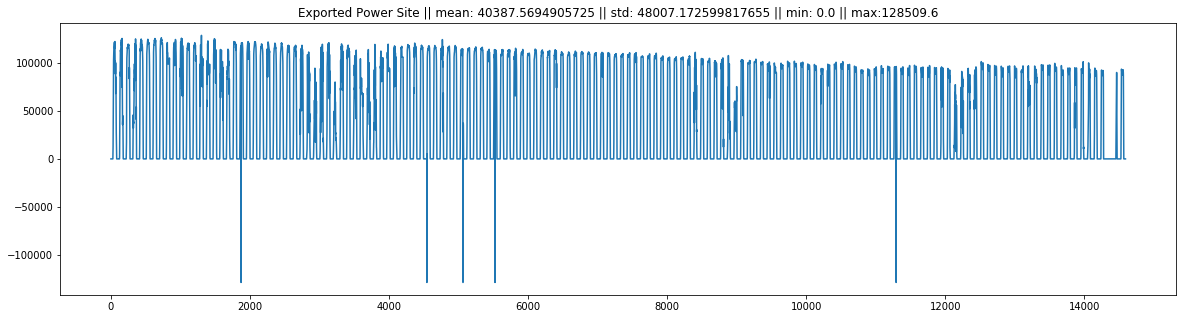

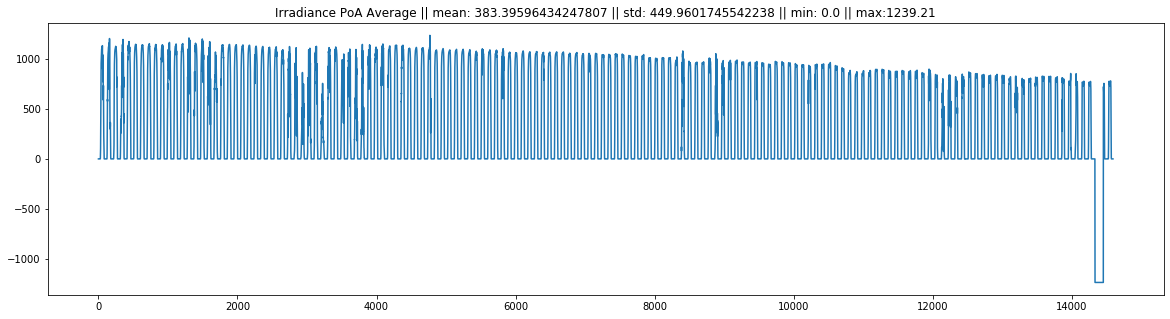

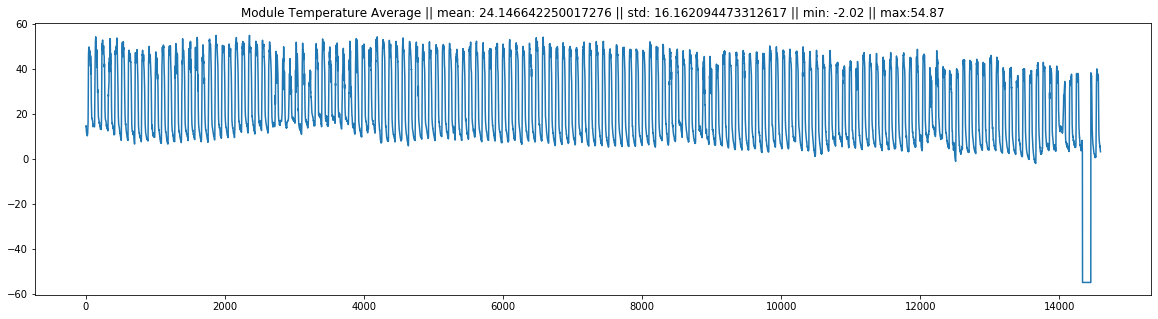

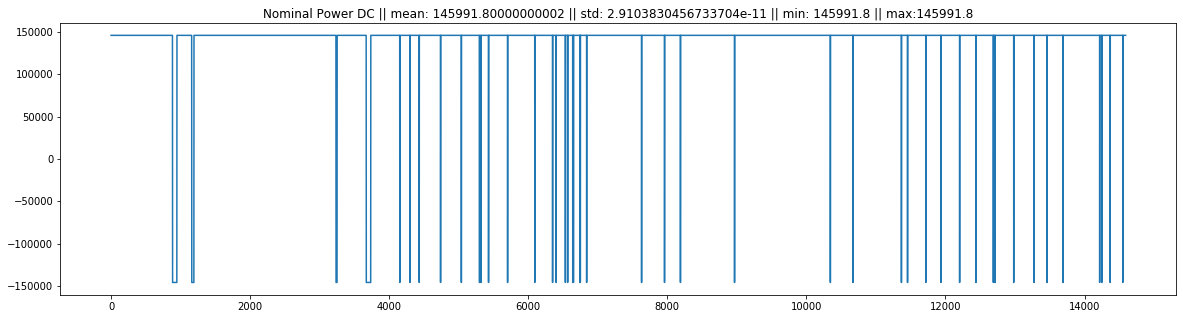

In [5]:
cols = df.columns[1:]
twin_df = df.copy()
twin_df[cols] = twin_df[cols].astype(float)
df_info = {i:"" for i in cols}
for i in cols:
    std = np.std(df[i].astype(float))  # i don't use twin_df here in order not to mess with the calculations
    mn = np.mean(df[i].astype(float))
    minimum = np.min(df[i].astype(float))
    maximum = np.max(df[i].astype(float))
    text = "|| mean: {} || std: {} || min: {} || max:{}".format(mn, std, minimum, maximum)
    
    nan_indicating_value = - np.max(np.abs(df[i].astype(float)))
    
    twin_df[i] = twin_df[i].fillna(nan_indicating_value)
    df_info[i] = {"mean":mn, "std":std, "min":minimum, "max":maximum}
    plt.figure(figsize=(20,5))
    plt.title(i+" "+text)
    plt.plot(twin_df[i]) # in order to check the actual values that would be nan otherwise.
    plt.show()

Indicate the NaN values as a large negative number, Since our actual values cant be negative apart from the temperature

In [6]:
pd.DataFrame.from_dict(df_info)

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
mean,40387.569491,383.395964,24.146642,1.459918e+05
std,48007.172600,449.960175,16.162094,2.910383e-11
min,0.000000,0.000000,-2.020000,1.459918e+05
max,128509.600000,1239.210000,54.870000,1.459918e+05


Just by noticing the plots it is straightforward to see that Irradiance and temperature average are highly correlated
(it makes sense since they are both affected by the same variable). 

Second step is to standardize the collumns before feeding it in the the timeseries predictor, since the values of the features are highly vary towards each other.

Also obvious from the plots that apart from the nan values there aren't any outliers in our dataset.

Finally show the worst/best results of our model.

In [7]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.index = df['Timestamp']
del df["Timestamp"]
df = df.astype(float)
df = df.resample('3600s').mean() #select timeslot. for now i select 3600 sec aka 60 min
df.head()
# the actual resampling should be considered a hyperparameter. Changing it's value tends to change the results slightly

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,
2019-01-01 00:00:00,0.0,0.0,14.4800,145991.8
2019-01-01 01:00:00,0.0,0.0,13.4225,145991.8
2019-01-01 02:00:00,0.0,0.0,11.6750,145991.8
2019-01-01 03:00:00,0.0,0.0,11.2725,145991.8
2019-01-01 04:00:00,0.0,0.0,10.5250,145991.8


In [8]:
df[df["Exported Power Site"].isnull()]

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,


There are several ways to tackle the Nan issue 

1. Either via interpolation or by taking the mean value of its neighbors (since we have very few nan samples compared to our actual dataset)
2. Eliminate the rows that contain these values since they don't provide actual information about our dataset

In our case the latter is the obvious solution since interpolation contains high risk when outliers are possible.

In [9]:
df["Nominal Power DC"].unique() # this feature seems that it cannot actually offer new information 

array([145991.8,      nan])

In [10]:
print("NaNs ration in nominal power",len(df[df["Nominal Power DC"].isnull()])/len(df["Nominal Power DC"]))

NaNs ration in nominal power 0.011510002740476843


"Nominal Power DC" has no statistical significance especially since it's either a constant or a nan value.

(You can easily add that feature and try to run the model but it will produce slightly worse results)

In [11]:
df[df["Nominal Power DC"].isnull()].head()

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,
2019-01-10 06:00:00,0.0000,0.0000,8.2875,NaN
2019-01-10 07:00:00,4368.5550,52.4150,8.5125,NaN
2019-01-10 08:00:00,56902.6825,530.1000,23.5225,NaN
2019-01-10 09:00:00,109225.9900,914.5600,40.5750,NaN
2019-01-10 10:00:00,116388.6900,1035.2425,46.6825,NaN


Amongst these features we could've added the feature of season aka winter, summer.
Which would be straightforward (Even though the majority of the timestamps belong to spring)

In [12]:
(df[df["Module Temperature Average"].isnull()]["Exported Power Site"]).unique()
# which means that when we have nan values 
# on the Module Temperature Average the site doesn't produce energy at all.

array([0.])

In [13]:
f_cols = list(set(df.columns) - set(["Nominal Power DC"]))
print(f_cols)
final_df = df[f_cols]

['Module Temperature Average', 'Irradiance PoA Average', 'Exported Power Site']


In [14]:
final_df.tail()

,Module Temperature Average,Irradiance PoA Average,Exported Power Site
Timestamp,,,
2019-06-01 20:00:00,7.14,0.0,0.0
2019-06-01 21:00:00,5.77,0.0,0.0
2019-06-01 22:00:00,5.25,0.0,0.0
2019-06-01 23:00:00,3.78,0.0,0.0
2019-06-02 00:00:00,3.18,0.0,0.0


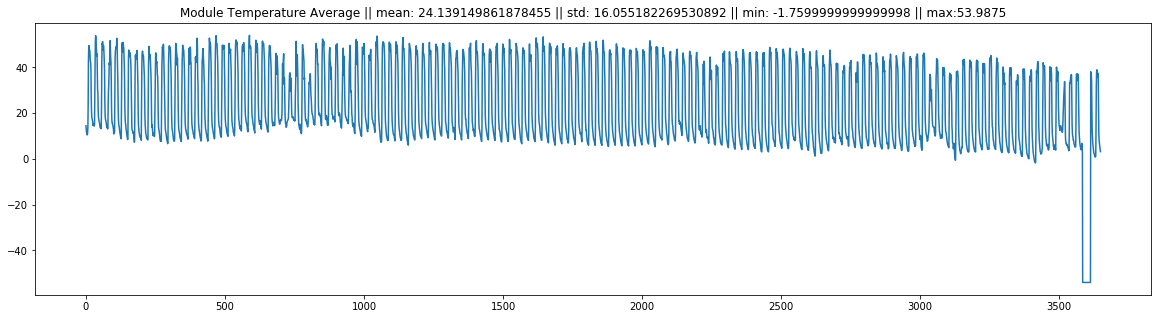

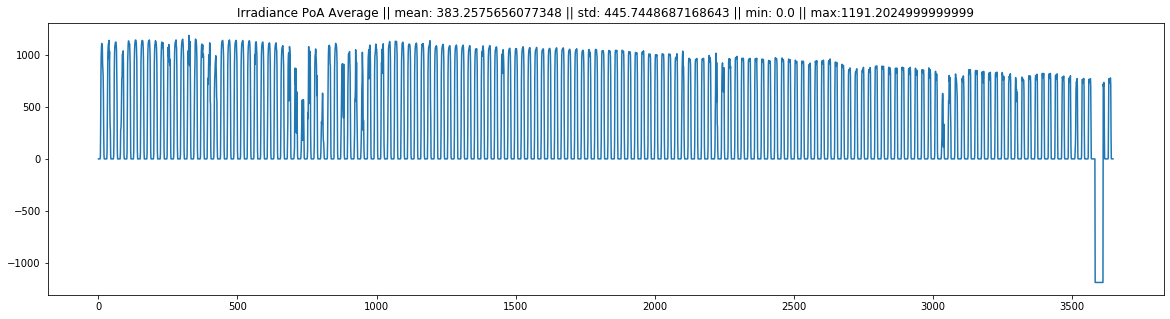

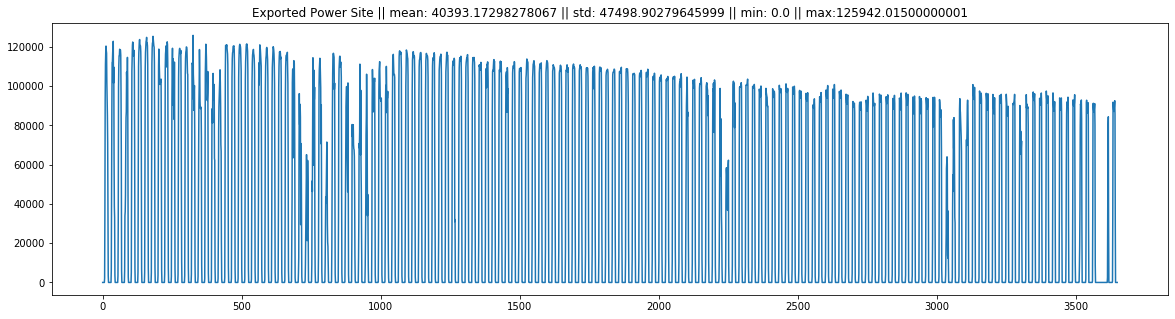

In [15]:
for i in f_cols:
    std = np.std(final_df[i].astype(float))  # i don't use twin_df here in order not to mess with the calculations
    mn = np.mean(final_df[i].astype(float))
    minimum = np.min(final_df[i].astype(float))
    maximum = np.max(final_df[i].astype(float))
    text = "|| mean: {} || std: {} || min: {} || max:{}".format(mn, std, minimum, maximum)
    
    nan_indicating_value = - np.max(np.abs(df[i].astype(float)))
    
    df_info[i] = {"mean":mn, "std":std, "min":minimum, "max":maximum}
    plt.figure(figsize=(20,5))
    plt.title(i+" "+text)
    plt.plot(final_df[i].fillna(nan_indicating_value).values.astype(float)) # in order to check the actual values that would be nan otherwise.
    plt.show()

In [16]:
final_df[final_df["Exported Power Site"].isnull()]

,Module Temperature Average,Irradiance PoA Average,Exported Power Site
Timestamp,,,


changing the nan value of exported Power Site to 0 should be correct since this value has to be a positive integer

In [17]:
final_df["Exported Power Site"] = final_df["Exported Power Site"].fillna(0)

/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
final_df = final_df.dropna() # actually drop the nan values since we can't make an inference out of them

In [19]:
final_df.isnull().any()

Module Temperature Average    False
Irradiance PoA Average        False
Exported Power Site           False
dtype: bool

In [20]:
final_df[f_cols] = final_df[f_cols].astype(float)

In [21]:
final_df.head()

,Module Temperature Average,Irradiance PoA Average,Exported Power Site
Timestamp,,,
2019-01-01 00:00:00,14.4800,0.0,0.0
2019-01-01 01:00:00,13.4225,0.0,0.0
2019-01-01 02:00:00,11.6750,0.0,0.0
2019-01-01 03:00:00,11.2725,0.0,0.0
2019-01-01 04:00:00,10.5250,0.0,0.0


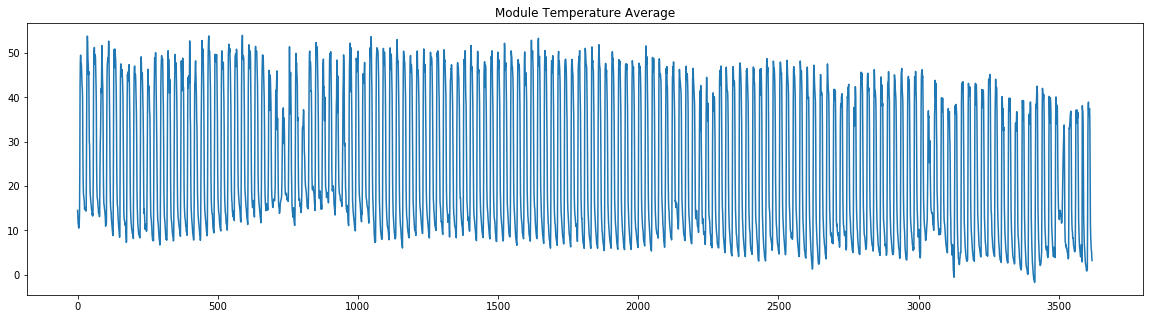

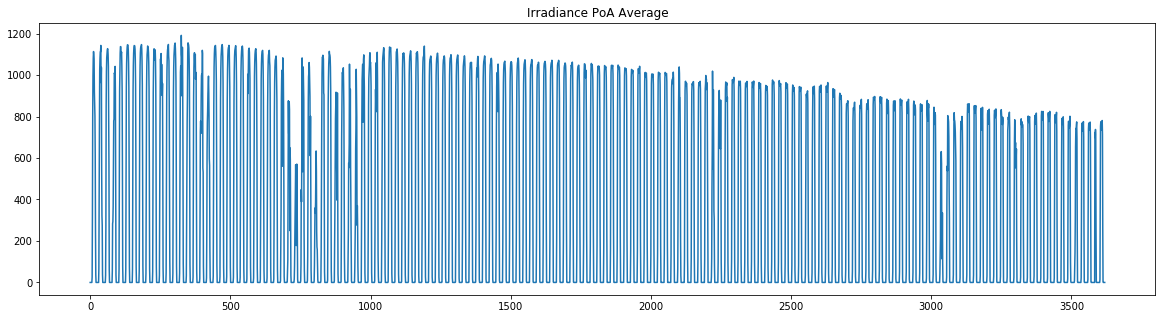

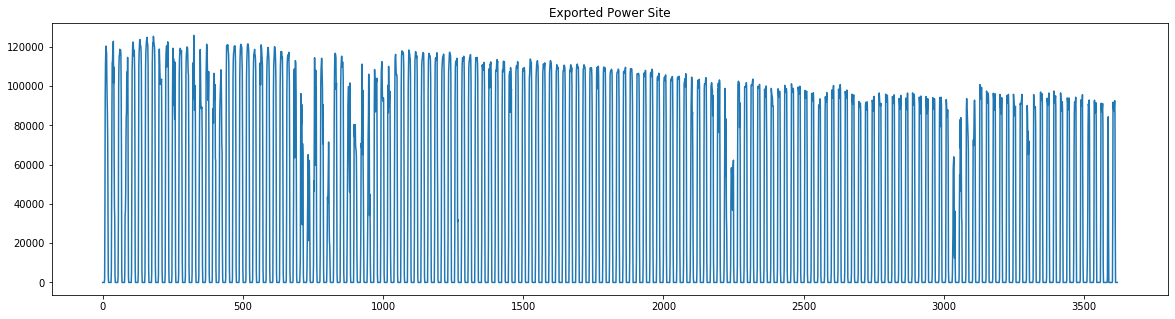

In [22]:
for i in f_cols:
    plt.figure(figsize=(20,5))
    plt.title(i)
    plt.plot(final_df[i].values) # in order to check the actual values that would be nan otherwise.
    plt.show()

In [23]:
split_index = (7 * final_df.shape[0])//10 # i am going to split the dataset 70% train 30% test

In [24]:
print(final_df.index.to_list()[split_index])
label = "Exported Power Site"

2019-04-16 14:00:00


In [25]:
def clear_sets(X_all, label):
    Y_series_train = X_all[label]
    del X_all[label]
    X_series_train = X_all
    return X_series_train, Y_series_train

Actually rescale data in order not to punish the data that contain significantly lower values.

In [26]:
final_df = (final_df - final_df.mean())/final_df.std()

In [27]:
series_train = final_df.loc[final_df.index <= final_df.index.to_list()[split_index]].copy()
X_series_train, Y_series_train = clear_sets(series_train, label)

In [28]:
series_test = final_df.loc[final_df.index > final_df.index.to_list()[split_index]].copy()
X_series_test, Y_series_test = clear_sets(series_test, label)

In [29]:
print("X, Y ", [i.shape for i in (X_series_train, Y_series_train)])
print("X, Y ", [i.shape for i in (X_series_test, Y_series_test)])

X, Y  [(2535, 2), (2535,)]
X, Y  [(1085, 2), (1085,)]


In [30]:
reg = xgb.XGBRegressor(n_estimators=1000) #since our data are not many we use high number of estimators

In [31]:
eval_metric = ["mae", "error"]
reg.fit(X_series_train, Y_series_train,
        eval_set=[(X_series_train, Y_series_train), (X_series_test, Y_series_test)],
        eval_metric=eval_metric,
        early_stopping_rounds=50,
       verbose=False)

[22:25:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

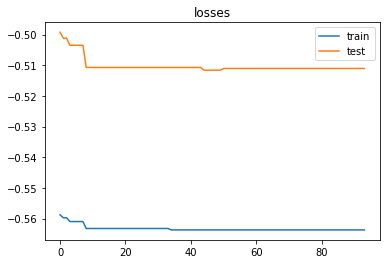

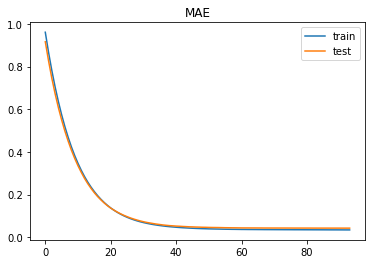

In [32]:
results = reg.evals_result()

plt.title("losses")
plt.plot(results['validation_0']["error"], label="train")
# plt.show()
plt.plot(results["validation_1"]["error"], label="test")
plt.legend()
plt.show()

plt.title("MAE")
plt.plot(results['validation_0']["mae"], label="train")
# plt.show()
plt.plot(results["validation_1"]["mae"], label="test")
plt.legend()
plt.show()

In [33]:
# the regressor is clearly NOT overfitting since we can see that the loss curves are parallelised.

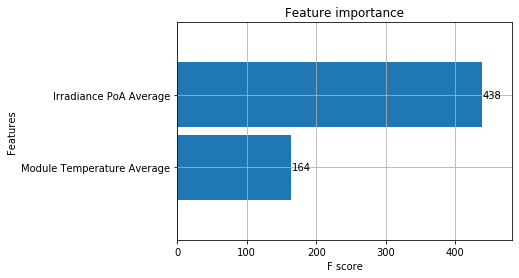

In [34]:
_ = plot_importance(reg, height=0.9)

In [35]:
y_test_predictions = reg.predict(X_series_test)
y_train_predictions = reg.predict(X_series_train)

r2 test score:  0.987569958047755


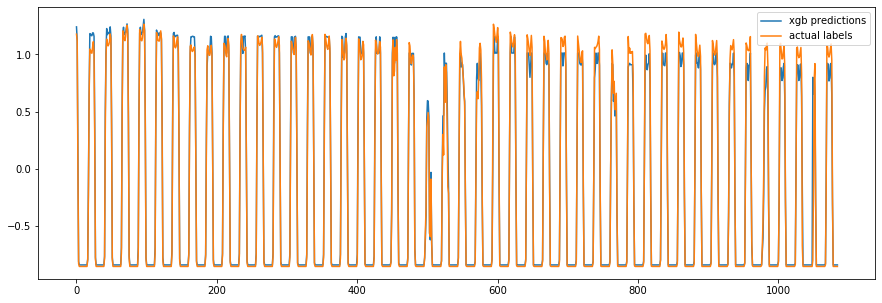

r2 train score:  0.992756877914197 train


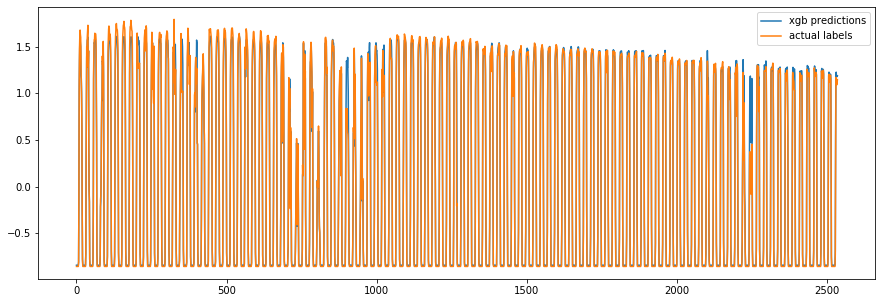

In [36]:
print("r2 test score: ", r2_score(y_test_predictions, Y_series_test.values))
plt.figure(figsize=(15,5))
plt.plot(y_test_predictions, label="xgb predictions")
plt.plot(Y_series_test.values, label="actual labels")
plt.legend(loc='upper right')
plt.show()

print("r2 train score: ",r2_score(y_train_predictions, Y_series_train.values),"train")
plt.figure(figsize=(15,5))
plt.plot(y_train_predictions, label="xgb predictions")
plt.plot(Y_series_train.values, label="actual labels")
plt.legend(loc='upper right')
plt.show()

In [ ]:
We can see that the actual labels follow the flow of the xgb predictions. So our model is achieving good predictions.
This is the actual reason

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [38]:
print("mean absolute error: ")
print(mean_absolute_error(y_test_predictions, Y_series_test.values))
print("mean squared error: ")
print(mean_squared_error(y_test_predictions, Y_series_test.values))

mean absolute error: 
0.04878265188310068
mean squared error: 
0.008884875145781998


In [39]:
MAE_results = np.abs(Y_series_test - y_test_predictions)

In [40]:
print("Datetime with the highest prediction error: ")
MAE_results[MAE_results==MAE_results.max()].index[0]
print("Max Error ", MAE_results.max())

Datetime with the highest prediction error: 
Max Error  1.6025319815321089


In [41]:
top_mae = MAE_results.sort_values(ascending=False)

Datetimes with worst predictions

In [42]:
top_mae.head(20)

Timestamp
2019-05-31 13:00:00    1.602532
2019-05-31 14:00:00    0.776412
2019-05-29 17:00:00    0.482540
2019-05-27 12:00:00    0.372076
2019-05-08 10:00:00    0.347017
2019-05-08 16:00:00    0.333965
2019-05-27 13:00:00    0.320046
2019-05-27 11:00:00    0.305582
2019-06-01 16:00:00    0.302754
2019-05-20 09:00:00    0.301045
2019-05-28 09:00:00    0.300207
2019-05-31 16:00:00    0.296515
2019-05-27 16:00:00    0.285772
2019-05-11 09:00:00    0.281632
2019-05-20 11:00:00    0.270691
2019-05-17 09:00:00    0.267593
2019-05-19 09:00:00    0.266926
2019-05-28 16:00:00    0.264854
2019-05-26 12:00:00    0.262510
2019-05-20 16:00:00    0.260771
Name: Exported Power Site, dtype: float64

Datetimes with best predictions

In [43]:
top_mae.tail(20)

Timestamp
2019-05-12 10:00:00    0.006322
2019-05-04 12:00:00    0.005550
2019-05-10 12:00:00    0.005299
2019-04-16 16:00:00    0.005085
2019-05-16 17:00:00    0.004643
2019-04-24 17:00:00    0.003947
2019-04-24 11:00:00    0.003782
2019-04-27 09:00:00    0.003666
2019-05-23 17:00:00    0.003583
2019-05-21 07:00:00    0.003396
2019-05-04 13:00:00    0.003305
2019-04-17 07:00:00    0.003251
2019-05-08 07:00:00    0.003113
2019-05-07 14:00:00    0.002440
2019-05-14 11:00:00    0.002249
2019-05-11 07:00:00    0.000659
2019-05-07 07:00:00    0.000651
2019-05-09 14:00:00    0.000581
2019-05-03 15:00:00    0.000201
2019-05-01 17:00:00    0.000049
Name: Exported Power Site, dtype: float64